In [1]:
# Neptune

In [2]:
import os
# !pip install swifter

In [3]:
# Path 

In [4]:
train_path = "../../data/local/train.csv"
test_path = "../../data/local/test.csv"

In [5]:
print("data")
print(train_path)
print(test_path)

data
../../data/local/train.csv
../../data/local/test.csv


In [6]:
# Load data 

In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.metrics import precision_recall_curve, accuracy_score
import seaborn as sns
from tqdm import tqdm
import swifter

In [8]:
df_train = pd.read_csv(train_path)

In [9]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,32456,1,1,"Benitez, Christy",female,45.0,1,0,47782,34.53,C20721,S
1,40212,0,2,"Dennis, Gary",male,32.0,0,0,202451,7.88,NaN,S
2,49626,1,1,"Oatney, Carol",female,29.0,1,2,PC 22646,82.21,B14660,C
3,17676,1,2,"Bailey, Ronnie",male,55.0,0,1,196804,9.65,NaN,S
4,29881,1,2,"Summers, Pamela",female,62.0,0,0,6878,27.76,NaN,S


In [10]:
df_train.count()

PassengerId    50000
Survived       50000
Pclass         50000
Name           50000
Sex            50000
Age            48370
SibSp          50000
Parch          50000
Ticket         47605
Fare           49945
Cabin          16066
Embarked       49881
dtype: int64

In [11]:
df_test = pd.read_csv(test_path)

In [12]:
df_test.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,86332,0,2,"Whitson, Ryan",male,24.0,0,0,A.5. 23091,25.16,NaN,S
1,58553,0,1,"Crossland, Winston",male,52.0,0,0,465968,27.69,C20653,S
2,91948,0,3,"Mullins, William",male,47.0,1,1,13873,13.06,NaN,S
3,92894,0,2,"Mcnamara, Richard",male,1.0,1,2,469361,32.94,NaN,S
4,29714,0,2,"Vogel, Richard",male,30.0,0,0,11235,7.03,NaN,S


# Feature Extraction 

In [13]:
from sklearn import preprocessing

## Encoding Sex

In [14]:
sex_encoder = preprocessing.LabelEncoder()

In [15]:
sex_encoder.fit(list(df_train["Sex"]) + list(df_test["Sex"]))

LabelEncoder()

In [16]:
df_train["Sex_feature"] = sex_encoder.transform(df_train["Sex"])

In [17]:
df_test["Sex_feature"] = sex_encoder.transform(df_test["Sex"])

## Encoding Embarked

In [18]:
embarked_encoder = preprocessing.LabelEncoder()
df_train["Embarked"] = df_train["Embarked"].fillna("UNK")
df_test["Embarked"] = df_test["Embarked"].fillna("UNK")

In [19]:
embarked_encoder.fit(list(df_train["Embarked"]) + list(df_test["Embarked"]))

LabelEncoder()

In [20]:
df_train["Embarked_feature"] = embarked_encoder.transform(df_train["Embarked"])

In [21]:
df_test["Embarked_feature"] = embarked_encoder.transform(df_test["Embarked"])

## Extract Cabin

In [22]:
cabin_encoder = preprocessing.LabelEncoder()

In [23]:
def extract_cabin_type(cabin_text):
    if cabin_text:
        cabin_type = cabin_text[0]
        return cabin_type
    else:
        return "U"

In [24]:
df_train["Cabin_type"] = df_train["Cabin"].fillna("U").swifter.apply(extract_cabin_type)


Pandas Apply:   0%|          | 0/50000 [00:00<?, ?it/s]

In [25]:
df_test["Cabin_type"] = df_test["Cabin"].fillna("U").swifter.apply(extract_cabin_type)

Pandas Apply:   0%|          | 0/50000 [00:00<?, ?it/s]

In [26]:
cabin_encoder.fit(list(df_train["Cabin_type"]) + list(df_test["Cabin_type"]))

LabelEncoder()

In [27]:
df_train["Cabin_type_feature"] = cabin_encoder.transform(df_train["Cabin_type"])

In [28]:
df_test["Cabin_type_feature"] = cabin_encoder.transform(df_test["Cabin_type"])

## Choice feature

In [29]:
choice_feature = ["Sex_feature", "Age", "Fare", "SibSp", "Pclass", "Embarked_feature", "Cabin_type_feature"]

In [30]:
X = df_train[choice_feature]
y = df_train["Survived"]

In [31]:
X_test = df_test[choice_feature]


In [32]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=3041975)

In [33]:
lgb_train_data = lgb.Dataset(data=X_train, label=y_train, categorical_feature=["Sex_feature", "Embarked_feature", "Pclass", "SibSp", "Cabin_type_feature"])

In [34]:
lgb_val_data = lgb.Dataset(data=X_val, label=y_val, reference=lgb_train_data)

In [35]:
# lgbm_params = {
#     'boosting': 'gbdt',          # dart (drop out trees) often performs better
#     'application': 'binary',     # Binary classification
#     'learning_rate': 0.02,       # Learning rate, controls size of a gradient descent step
#     'min_data_in_leaf': 100,      # Data set is quite small so reduce this a bit
#     'feature_fraction': 0.7,     # Proportion of features in each boost, controls overfitting
#     'metric': 'auc',  # Area under ROC curve as the evaulation metric,
#     'lambda_l1': 5e-05, 
#     'lambda_l2': 1.35e-08, 
#     'num_leaves': 216, 
#     'feature_fraction': 0.7458519562366559, 
#     'bagging_fraction': 0.7835116194444349, 
#     'bagging_freq': 2, 
#     'min_child_samples': 95
# }

In [36]:
# lgbm_params = {
#     'boosting': 'gbdt',          # dart (drop out trees) often performs better
#     'application': 'binary',     # Binary classification
#     'learning_rate': 0.001,       # Learning rate, controls size of a gradient descent step
#     # 'feature_fraction': 0.7,     # Proportion of features in each boost, controls overfitting
#     'metric': 'auc',  # Area under ROC curve as the evaulation metric,
#     'lambda_l1': 5e-05, 
#     'lambda_l2': 1.35e-08, 
#     'num_leaves': 216, 
# }

In [37]:
lgbm_params = {
    'boosting': 'gbdt',          # dart (drop out trees) often performs better
    'objective': 'binary',     # Binary classification
}

In [38]:
# experiment = neptune.create_experiment(name='LightGBM-training', params=lgbm_params)

In [39]:
num_boost_round = 5000
# from neptunecontrib.monitoring.lightgbm import neptune_monitor
model = lgb.train(lgbm_params, lgb_train_data, valid_sets = [lgb_train_data, lgb_val_data], valid_names=["train_data", "val_data"], verbose_eval=500, num_boost_round=num_boost_round)

/home/tt/miniconda3/envs/ml/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/tt/miniconda3/envs/ml/lib/python3.8/site-packages/lightgbm/basic.py:1554: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Cabin_type_feature', 'Embarked_feature', 'Pclass', 'Sex_feature', 'SibSp']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
/home/tt/miniconda3/envs/ml/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/tt/miniconda3/envs/ml/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] Number of positive: 19372, number of negative: 25628
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.033614 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 414
[LightGBM] [Info] Number of data points in the train set: 45000, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.430489 -> initscore=-0.279857
[LightGBM] [Info] Start training from score -0.279857
[500]	train_data's binary_logloss: 0.400461	val_data's binary_logloss: 0.493182
[1000]	train_data's binary_logloss: 0.361383	val_data's binary_logloss: 0.508051
[1500]	train_data's binary_logloss: 0.331094	val_data's binary_logloss: 0.522949
[2000]	train_data's binary_logloss: 0.306545	val_data's binary_logloss: 0.53758
[2500]	train_data's binary_logloss: 0.285569	val_data's binary_logloss: 0.553912
[3000]	train_data's binary_logloss: 0.

# Evaluation 

In [40]:
flag = False

In [41]:
if "local" in train_path:
    flag = True

In [42]:
flag

True

In [43]:
y_pred = model.predict(X_test, num_iteration=model.best_iteration)

In [44]:
if flag:
    y_test = df_test["Survived"]
    precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
    df_curve = pd.DataFrame({"precision": precision, "recall": recall})
    

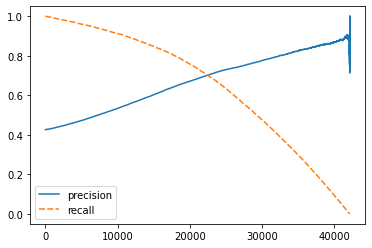

In [45]:
if flag:
    sns.lineplot(data=df_curve)

In [46]:
thresholds_meow = [i*0.01 for i in range(1,100)]

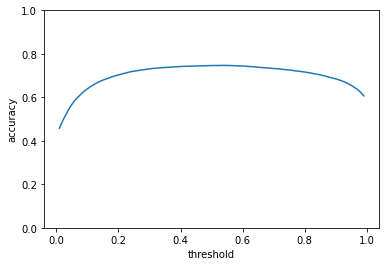

In [47]:
if flag: 
    acc_list = []
    for threshold in thresholds_meow:
        y_pred_one = [1 if y > threshold else 0 for y in y_pred]
        accuracy = accuracy_score(y_test, y_pred_one)
        acc_list.append(accuracy)
    df_acc = pd.DataFrame({"threshold":thresholds_meow, "accuracy":acc_list})
    ax = sns.lineplot(data=df_acc, x="threshold", y="accuracy")
    ax.set_ylim(0, 1)

In [48]:
if flag:
    max_acc = max(acc_list)
    max_index = acc_list.index(max_acc)
    best_threshold = thresholds_meow[max_index]
    print("Best Acc ", max_acc)
    print("Best threshold ", best_threshold)



Best Acc  0.74688
Best threshold  0.54


## Online submission

In [49]:
if not flag:
    best_threshold = 0.5
    y_pred_one = [1 if y > best_threshold else 0 for y in y_pred]
    df_submission = pd.DataFrame({"PassengerId":df_test["PassengerId"], "Survived": y_pred_one})
    display(df_submission)
    df_submission.to_csv("submission.csv", index=False)